### Using FISSA with cNMF
cNMF is blind source separation toolbox for cell detection and signal extraction. 

Here we illustrate how one can use the ROIs detected by cNMF, and use FISSA to extract and decontaminate the traces.

This also serves as a tutorial on how to import Matlab format data.

For more information about the cNMF toolbox see: 

https://github.com/epnev/ca_source_extraction

Pnevmatikakis, E. A., Soudry, D., Gao, Y., Machado, T. A., Merel, J., Pfau, D., Reardon, T., Mu, Y., Lacefield, C., Yang, W., Ahrens, M., Bruno, R., Jessell, T. M., Peterka, D. S., Yuste, R., Paninski, L., 2015. Simultaneous Denoising, Deconvolution, and Demixing of Calcium Imaging Data. Neuron 89, 285–299


#### Imports

In [1]:
# Plotting toolbox
import holoviews as hv
%load_ext holoviews.ipython

# file operations
import glob
from scipy.io import loadmat

# FISSA
import fissa

/usr/local/lib/python2.7/dist-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


Plotting option so plots are embedded not rendered live

In [2]:
%output widgets='embed'

#### Running cNMF in MATLAB, and importing them into Python
We applied cNMF using the run_pipeline.m script from the cNMF repository on the example data in this repository (../exampleData/20150529/), and saving the Coor and F_df variables generated by that script in a standard .mat file, which we load here:

In [3]:
# load data
cNMFdata = loadmat('cNMFdata')['dat']

# get F_df traces out
F_df = cNMFdata['F_df'][0,0]

# get ROI outlines out
Coor = cNMFdata['Coor'][0,0]

#### Show detected cells

:Overlay
   .Curve.I   :Curve   [x]   (y)
   .Curve.II  :Curve   [x]   (y)
   .Curve.III :Curve   [x]   (y)
   .Curve.IV  :Curve   [x]   (y)
   .Curve.V   :Curve   [x]   (y)
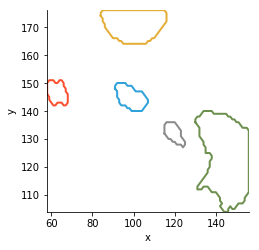

In [4]:
fig = hv.Overlay()
for i in range(len(Coor)):
    x = Coor[i,0][0]
    y = Coor[i,0][1]
    fig*=hv.Curve(zip(x,y))
fig

#### Use FISSA with cNMF detected cells

FISSA needs either ImageJ ROIs or numpy arrays as inputs for the ROIs. 

cNMF can output ROIs in coordinates (as we imported above), which can be directly read into FISSA.
A given roi after importing from MATLAB is given as

```
Coor[i,0]
```

FISSA expects a set of rois to be given as a list of lists

```
[[roiA1,roiA2,roiA3...]]
```
So some formatting will need to be done first.

In [5]:
numROI = len(Coor)
rois_FISSA = [[Coor[i,0][0],Coor[i,0][1]] for i in range(numROI)]

Which can then be put into FISSA and run

In [6]:
output_folder = 'fissa_cnmf_example'
tiff_folder = 'exampleData/20150529/'
exp = fissa.Experiment(tiff_folder,[rois_FISSA], output_folder)
exp.separate(redo_prep=True)

Reloading previously prepared data...
Reloading previously separated data...
Doing region growing and data extraction....
Doing signal separation....
NMF converged after 569 iterations.
Finished ROI number 2
NMF converged after 582 iterations.
NMF converged after 548 iterations.
Finished ROI number 0
Finished ROI number 1
NMF converged after 632 iterations.
Finished ROI number 3
NMF converged after 614 iterations.
Finished ROI number 4


#### Plotting the results
Comparing FISSA to cNMF extraction

:Layout
   .HoloMap.I  :HoloMap   [Cell]
      :Overlay
         .Curve.I    :Curve   [x]   (y)
         .Curve.II   :Curve   [x]   (y)
         .Curve.III  :Curve   [x]   (y)
         .Curve.IV   :Curve   [x]   (y)
         .Curve.V    :Curve   [x]   (y)
         .Curve.VI   :Curve   [x]   (y)
         .Curve.VII  :Curve   [x]   (y)
         .Curve.VIII :Curve   [x]   (y)
         .Curve.IX   :Curve   [x]   (y)
         .Curve.X    :Curve   [x]   (y)
   .HoloMap.II :HoloMap   [Cell]
      :Overlay
         .Curve.CNMF  :Curve   [x]   (y)
         .Curve.FISSA :Curve   [x]   (y)
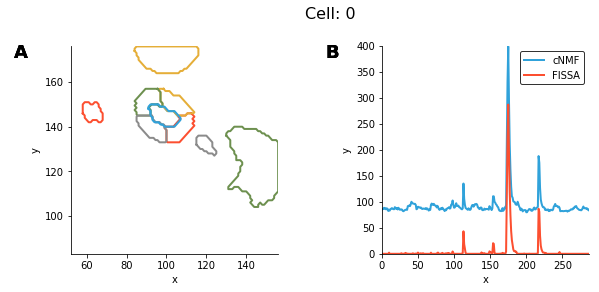
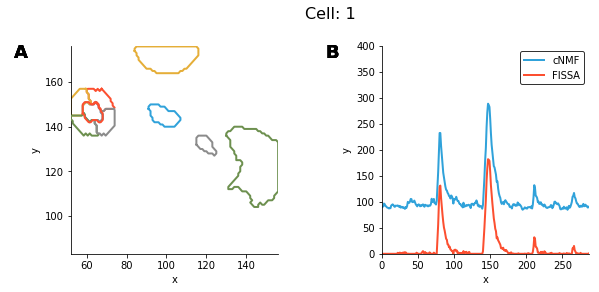
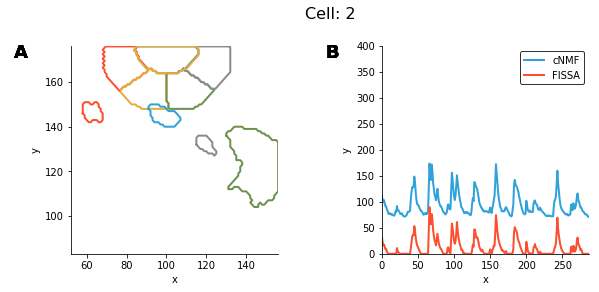
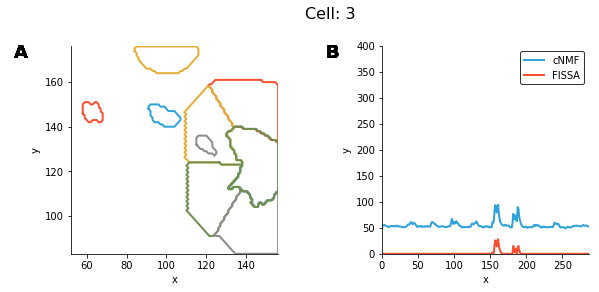
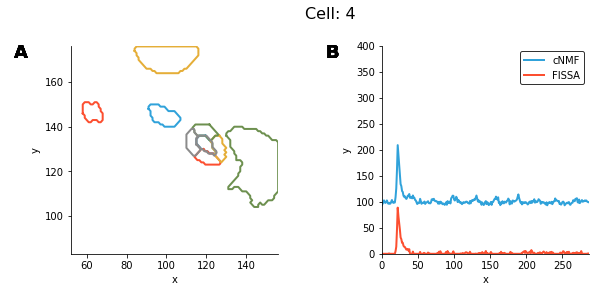

In [7]:
%%opts Curve {+axiswise}
# function for a single cell region plot
def plot_cell_regions(cell):
    out = hv.Overlay()
    numReg = len(exp.roi_polys[cell,0]) # Number of regions
    for i in range(numReg):
        x = exp.roi_polys[cell,0][i][0][:,1]
        y = exp.roi_polys[cell,0][i][0][:,0]
        out *= hv.Curve(zip(x,y))
    return out

# get plots for all detected regions
region_plots = {i : plot_cell_regions(i) for i in range(exp.nCell)}

# get plots for raw extracts and neuropil removed
traces_plots = {i : hv.Curve(exp.raw[i][1][0,:], label='cNMF')*hv.Curve(exp.result[i][1][0,:], label='FISSA') for i in range(exp.nCell)}

hv.HoloMap(region_plots,kdims=['Cell'])*fig+hv.HoloMap(traces_plots,kdims=['Cell'])

(A) ROI contours, and the neuropil subregions defined by FISSA for the current cell.

(B) Signal extracted by cNMF (blue), and after FISSA (red)